In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading and Preprocessing Data

In [2]:
amazon_df = pd.read_csv('AMZN_Daily_10year.csv')

In [3]:
def load_data(df, start, end):
    """
    Load data for the date range.

    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [4]:
START_DATE = dt.datetime(2013,11,1)
END_DATE = dt.datetime(2021,11,1)

START_DATE_TEST = END_DATE

In [5]:
# Convert 'Date' to datetime format

amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])

In [6]:
# Load the training data and scale the data.
# combined the scaled data into one array with dim [2012, 1]
# Also prepare the test inputs

# Set the number of days used for prediction
prediction_days = 120

#prepare training data
train_data = load_data(amazon_df,
                 start = START_DATE,
                 end = END_DATE)

scaler = MinMaxScaler() # default [0,1]
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

# prepare the test data
test_data = load_data(amazon_df,
start=START_DATE_TEST,
end=dt.datetime.now()
)

actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [7]:
# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays it should have dimensions (1977,35,1)

In [8]:
x_train.shape

(1892, 120, 1)

# LSTM Model


In [9]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 70 units, input shape, and return sequences
    model.add(LSTM(units=64, recurrent_dropout=0.2, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

     # Add a second LSTM layer with 70 units and return sequences
    model.add(LSTM(units=64, recurrent_dropout=0.2, return_sequences=True))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

    # Add a third LSTM layer with 70 units
    model.add(LSTM(units=64, recurrent_dropout=0.2))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))
    
    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [10]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 120, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 83009 (324.25 KB)
Trainable params: 83009 (324.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
)

Epoch 1/25
60/60 [==============================] - 11s 143ms/step - loss: 0.0159
Epoch 2/25
60/60 [==============================] - 9s 145ms/step - loss: 7.1017e-04
Epoch 3/25
60/60 [==============================] - 9s 148ms/step - loss: 7.4918e-04
Epoch 4/25
60/60 [==============================] - 9s 148ms/step - loss: 7.0476e-04
Epoch 5/25
60/60 [==============================] - 9s 149ms/step - loss: 6.4241e-04
Epoch 6/25
60/60 [==============================] - 9s 158ms/step - loss: 6.7330e-04
Epoch 7/25
60/60 [==============================] - 9s 152ms/step - loss: 6.0115e-04
Epoch 8/25
60/60 [==============================] - 9s 154ms/step - loss: 5.7404e-04
Epoch 9/25
60/60 [==============================] - 9s 150ms/step - loss: 6.3264e-04
Epoch 10/25
60/60 [==============================] - 9s 147ms/step - loss: 5.5006e-04
Epoch 11/25
60/60 [==============================] - 9s 153ms/step - loss: 5.4737e-04
Epoch 12/25
60/60 [==============================] - 9s 156ms/step

# Inference

In [12]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

16/16 [==============================] - 1s 21ms/step


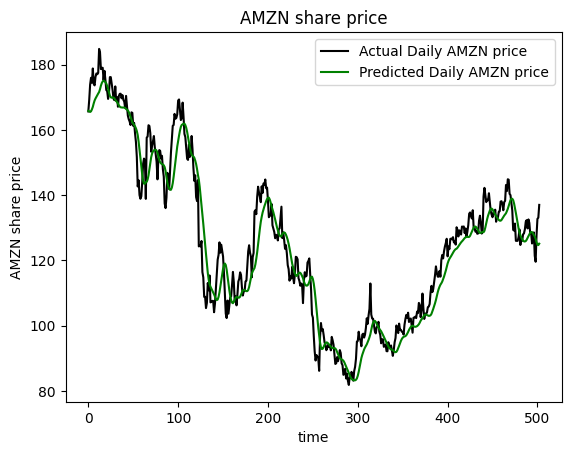

In [13]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Daily AMZN price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Daily AMZN price")

# Set the title of the plot using the company name
plt.title(f"AMZN share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"AMZN share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

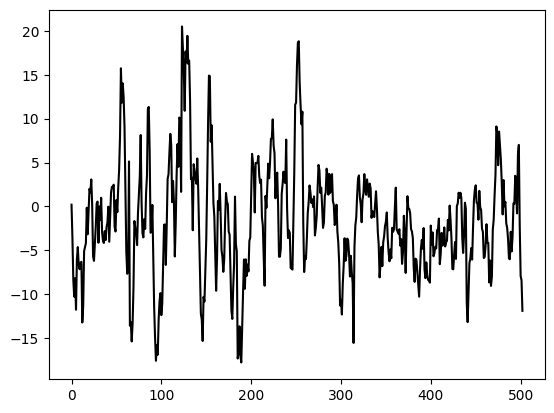

In [14]:
plt.plot(predicted_prices.flatten() - actual_prices, color='black', label=f"Actual Daily AMZN price")
plt.show()

In [15]:
# Extract the last 'prediction_days' values from the model inputs to make a prediction for the future
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data) #prediction for 10/30

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 0s 272ms/step
Prediction: 126.12014770507812


# Evaluation

In [16]:
predicted_prices1D = predicted_prices.flatten()

#using the same x_test that was input for the LSTM
#using prediction_days = 150

# Initialize an empty list to store moving averages
moving_averages = np.empty((len(predicted_prices1D), ), dtype=np.float64)

# Loop through x_test to consider
# every window of size prediction_days
for i in range(len(x_test)):

    # get the current window
    window = x_test[i].flatten()

    # Calculate the average of current window
    window_average = np.mean(window)

    # Store the average of current
    # window in moving average list
    moving_averages[i] = window_average

rolling_average = scaler.inverse_transform(moving_averages.reshape(-1, 1))
rolling_average = rolling_average.flatten()

In [17]:
# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the rolling mean of the actual target values
#actual_mean = np.mean(actual_prices) # compare to rolling mean of window

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - rolling_average) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)

Avergae percent error:  4.120531549715689
Root Mean Square Error (RMSE): 6.623058200390897
Out-of-sample R-squared: 0.8713652481897654


60.17157174934925